In [1]:
import torch, random
import numpy as np
import torch.nn.functional as F
from tqdm.auto import tqdm
from IPython.display import Audio
from matplotlib import pyplot as plt
from diffusers import DiffusionPipeline
from torchaudio import transforms as AT
from torchvision import transforms as IT

/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Load a pre-trained audio diffusion pipeline
device = "cuda:3" if torch.cuda.is_available() else "cpu"
pipe = DiffusionPipeline.from_pretrained("teticio/audio-diffusion-instrumental-hiphop-256").to(device)

unet/diffusion_pytorch_model.safetensors not found
Loading pipeline components...: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:29<00:00, 33.46it/s]


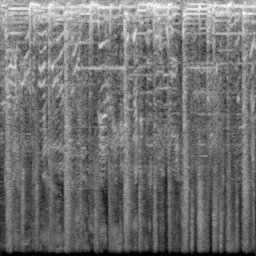

In [13]:
# Sample from the pipeline and display the outputs
output = pipe()
display(output.images[0])
display(Audio(output.audios[0], rate=pipe.mel.get_sample_rate()))

In [4]:
output

BaseOutput([('audios',
             array([[[-0.0013062 , -0.00141159, -0.00148867, ..., -0.00116214,
                      -0.00104888, -0.00096882]]], dtype=float32)),
            ('images', [<PIL.Image.Image image mode=L size=256x256>])])

In [5]:
output.audios[0].shape

(1, 130560)

In [6]:
pipe.mel

Mel {
  "_class_name": "Mel",
  "_diffusers_version": "0.27.2",
  "hop_length": 512,
  "n_fft": 2048,
  "n_iter": 32,
  "sample_rate": 22050,
  "top_db": 80,
  "x_res": 256,
  "y_res": 256
}

tensor(2.1130e-14) tensor(0.3497) tensor(0.0012) tensor(0.0092)


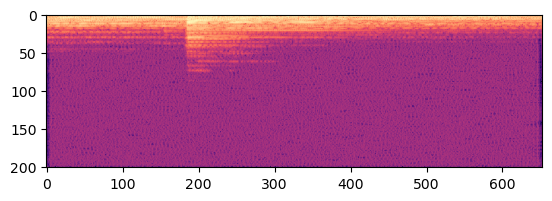

In [7]:
# Calculate and show a spectrogram for our generated audio sample using torchaudio
spec_transform = AT.Spectrogram(power=2)
spectrogram = spec_transform(torch.tensor(output.audios[0]))
print(spectrogram.min(), spectrogram.max(), spectrogram.mean(), spectrogram.std())
log_spectrogram = spectrogram.log()
plt.imshow(log_spectrogram[0], cmap="magma")

In [8]:
to_audio = pipe.mel.image_to_audio(output.images[0])
to_audio.shape

(130560,)

In [14]:
sample_rate_pipeline = pipe.mel.get_sample_rate()
sample_rate_pipeline

22050

In [10]:
Audio(to_audio, rate=sample_rate_pipeline)

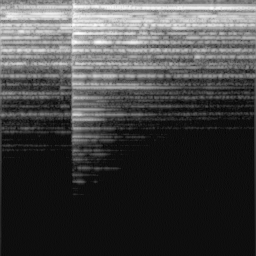

In [11]:
pipe.mel.load_audio(raw_audio=to_audio)
to_image = pipe.mel.audio_slice_to_image(0)
to_image

## Fine-Tuning the AudioPipeline

In [2]:
from datasets import load_dataset

dataset = load_dataset("lewtun/music_genres", split="train")
dataset

Dataset({
    features: ['audio', 'song_id', 'genre_id', 'genre'],
    num_rows: 19909
})

In [3]:
for g in list(set(dataset["genre"])):
    print(g, sum(x == g for x in dataset["genre"]))

Chiptune / Glitch 1181
Ambient Electronic 796
Country 142
Punk 2582
Jazz 306
Pop 945
Soul-RnB 94
International 814
Experimental 1800
Blues 58
Folk 1214
Old-Time / Historic 408
Instrumental 1044
Electronic 3071
Spoken 94
Hip-Hop 1757
Easy Listening 13
Rock 3095
Classical 495


In [6]:
dataset[301]

{'audio': {'path': None,
  'array': array([ 0.        ,  0.        ,  0.        , ..., -0.27662391,
         -0.27620055, -0.24533275]),
  'sampling_rate': 44100},
 'song_id': 385,
 'genre_id': 0,
 'genre': 'Electronic'}

In [7]:
audio_array = dataset[301]["audio"]["array"]
sample_rate_dataset = dataset[301]["audio"]["sampling_rate"]
print("Audio array shape:", audio_array.shape)
print("Sample rate:", sample_rate_dataset)
display(Audio(audio_array, rate=sample_rate_dataset))

Audio array shape: (1323119,)
Sample rate: 44100


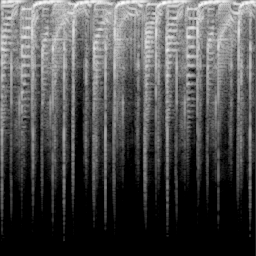

In [10]:
audio_array = dataset[301]["audio"]["array"]  # Get the audio array
pipe.mel.load_audio(raw_audio=audio_array)  # Load it with pipe.mel
pipe.mel.audio_slice_to_image(0)  # View the first 'slice' as a spectrogram

In [11]:
sample_rate_dataset = dataset[0]["audio"]["sampling_rate"]
sample_rate_dataset

44100

In [15]:
resampler = AT.Resample(sample_rate_dataset, sample_rate_pipeline, dtype=torch.float32)
to_t = IT.ToTensor()


def to_image(audio_array):
    audio_tensor = torch.tensor(audio_array).to(torch.float32)
    audio_tensor = resampler(audio_tensor)
    pipe.mel.load_audio(raw_audio=np.array(audio_tensor))
    num_slices = pipe.mel.get_number_of_slices()
    slice_idx = random.randint(0, num_slices - 1)  # Pic a random slice each time (excluding the last short slice)
    im = pipe.mel.audio_slice_to_image(slice_idx)
    return im

In [19]:
def collate_fn(examples):
    # to image -> to tensor -> rescale to (-1, 1) -> stack into batch
    audio_ims = [to_t(to_image(x["audio"]["array"])) * 2 - 1 for x in examples]
    return torch.stack(audio_ims)


# Create a dataset with only the 'Chiptune / Glitch' genre of songs
batch_size = 6  # 4 on colab, 12 on A100
chosen_genre = "Electronic"  # <<< Try training on different genres <<<
indexes = [i for i, g in enumerate(dataset["genre"]) if g == chosen_genre]
filtered_dataset = dataset.select(indexes)
dl = torch.utils.data.DataLoader(
    filtered_dataset.shuffle(), batch_size=batch_size, collate_fn=collate_fn, shuffle=True
)
batch = next(iter(dl))
print(batch.shape)

torch.Size([6, 1, 256, 256])


In [17]:
device = "cuda:3" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)

In [20]:
epochs = 5
lr = 1e-4

pipe.unet.train()
pipe.scheduler.set_timesteps(1000)
optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=lr)

for epoch in range(epochs):
    for step, batch in tqdm(enumerate(dl), total=len(dl)):

        # Prepare the input images
        clean_images = batch.to(device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(0, pipe.scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        noisy_images = pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

 28%|██▊       | 142/512 [04:45<12:23,  2.01s/it]Exception ignored from cffi callback <function SoundFile._init_virtual_io.<locals>.vio_read at 0x7f83d12025e0>:
Traceback (most recent call last):
  File "/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/soundfile.py", line 1244, in vio_read
    try:
KeyboardInterrupt: 
 29%|██▊       | 147/512 [04:55<12:43,  2.09s/it]

100%|██████████| 1000/1000 [00:24<00:00, 41.05it/s]


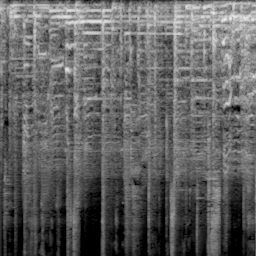

In [22]:
output = pipe()
display(output.images[0])
display(Audio(output.audios[0], rate=22050))

In [23]:
# Make a longer sample by passing in a starting noise tensor with a different shape
# noise = torch.randn(1, 1, pipe.unet.sample_size[0], pipe.unet.sample_size[1] * 4).to(device)
# output = pipe(noise=noise)
# display(output.images[0])
# display(Audio(output.audios[0], rate=22050))